In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import train_test_split


from data import *
from helpers import *


In [32]:
# Automated way to create labeled dataset
#directory='/../data_gated/'
#columns=['FSC-H', 'SSC-H', 'B530-H', 'B572-H', 'B675-H']
#create_labeled_dataset(directory,columns,label_gated=3,label_not_gated=1)

In [33]:
file = '../labeled_dataset/GL55_DN_3A.csv'
columns=['B530-H', 'B530-A','B675-H','B572-H','Width','FSC-H','SSC-H']
X,y = preprocess(file,columns)

### DBSCAN

In [19]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [18]:
labels_true = y.to_list()
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("F1-score: %0.3f"
      % f1_score(labels_true, labels, average='micro'))
print("Rand Index: %0.3f"
      % metrics.rand_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 289
F1-score: 0.003
Rand Index: 0.980
Adjusted Rand Index: 0.093


## K means

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [35]:
labels_true = y.to_list()
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("F1-score: %0.3f"
      % f1_score(labels_true, labels, average='micro'))
print("Rand Index: %0.3f"
      % metrics.rand_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Estimated number of noise points: 0
F1-score: 0.223
Rand Index: 0.653
Adjusted Rand Index: 0.721


/home/mika/.local/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +


## FlowGrid

In [4]:
run_FlowGrid(nbins=2,eps=1.2,isEvaluation=True)

In [5]:
output_labels = np.genfromtxt('fc_data_FlowGrid_label.csv', delimiter=',')

In [6]:
print(output_labels.shape)
print(X.shape)
print(y.shape)

(85646,)
(85647, 7)
(85647,)


<AxesSubplot:xlabel='B530-H', ylabel='B572-H'>

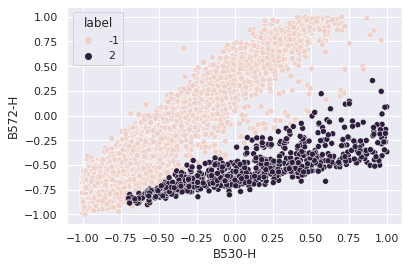

In [7]:
sns.scatterplot(data=X, x="B530-H", y="B572-H", hue=y)

In [28]:
X = X.drop([0])
y = y.drop([0])

KeyError: '[0] not found in axis'

<AxesSubplot:xlabel='B530-H', ylabel='B572-H'>

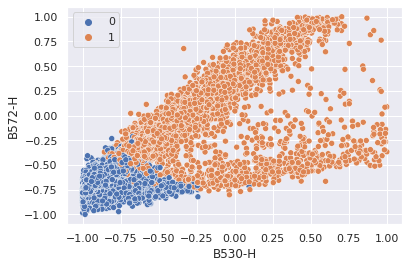

In [30]:
sns.scatterplot(data=X, x="B530-H", y="B572-H", hue=labels)

## Evaluation

In [10]:
y_true = y.to_list()
y_pred = output_labels.tolist()

In [12]:
unique, counts = np.unique(y, return_counts=True)
print("True label"+str(dict(zip(unique, counts))))
unique, counts = np.unique(output_labels, return_counts=True)
print("FlowGrid label"+str(dict(zip(unique, counts))))

True label{-1: 84970, 2: 676}
FlowGrid label{-1.0: 847, 1.0: 1188, 2.0: 406, 3.0: 3289, 4.0: 79916}


### F1 score

Provide a value between 0 and 1 for each cluster, with 1 indicating a perfect reproduction of the corresponding manually gated population. Since we want to match clusters to reference population (manually gated clusters), we have to change a bit the methodology and use an algorithm called the “Hungarian assignment algorithm” which solves the assignment problem by finding a one-to-one mapping that maximizes the sum of F1-scores across reference population.


Hungarian assigment would come during the mapping (clustering algorithm) and is not yet implemented

In [13]:
f1_score(y_true, y_pred, average='micro') #micro because class imbalance https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

0.014326413375989538

### RI

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.


Perfectly matching labelings have a score of 1 even.
Labelings that assign all classes members to the same clusters are complete but may not always be pure, hence penalized:

In [14]:
rand_score(y_true, y_pred)

0.8759010432295533

### ARI

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

(Similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.)

In [15]:
adjusted_rand_score(y_true,y_pred)

0.10855519616292277

### Crossvalidation with DBSCAN

In [15]:
from sklearn.metrics import homogeneity_score, make_scorer

def score_func(y_true, y_pred, **kwargs):
    return homogeneity_score(y_true, y_pred)
scorer = make_scorer(score_func)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


model = DBSCAN(n_jobs=-1)

param_grid = {"min_samples":np.arange(10),
             "eps":[1.1,1.2]}

grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scorer, cv=3)


In [17]:
#grid_result = grid.fit(X_train, y_train)


## Let's try another file

In [18]:
file = '../labeled_dataset/GL59_DN_2A.csv'
columns=['FSC-H', 'SSC-H', 'B530-H', 'B675-H','Width']
X,y = preprocess(file,columns)